**Outline**

* Neural Network
    * [Regression](#nn_reg)
        * [Tune Parameters](#param_tune)
        * [Model Selection](#model_selection_cv_nn_regression)
        * [Interpreting the model by ALE plot](#ale)
    * [Classification](#nn_cla)

* Tree        
   * [Regression](#tree_reg)
   * [Classification](#tree_cla)

---

### Neural Network

![](_pic/nn1.png)

**General Ideas about neural network**

Suppose, 

* There are k features in the model
* The number of node in the hidden layer is M
* The number of output is 1 for regression neural network

For each node, we will need $k+1$ parameters, and there are M nodes. Therefore, in the input to hidden layer, we'll need $M \times (k+1)$ parameters.

From hidden to output layer, we will need $M+1$ parameters.

Totally, we need $M \times (k+1) + (M + 1)$ parameters to fit this neural network model.

**Steps to fit a neural network model**

1. Standardize predictors. Due to the high flexibility of the model, it is very easy to overfit the data. To solve this, we add a regularization term in the cost function. We want to standardize our features before fitting the model since we want to give the same shrinkage weight to all the predictors. If we don’t scale it, the predictor with larger range will shrink more. In other words, the weight of shrink will be different.

2. Standard the response. For a prediction problem the model is learning an approximation of the function between the input and output data. Commonly this is done through gradient descent which relies on calculation of the error between predictions and true values for each instance. Now obviously your gradient descent wont work if your model output is constrained to a range of values by your activation function (such as Sigmoid with range [0, 1]) which your real output values fall outside of. 

3. choose
    * hidden layers 
    * nodes in each hidden layer
    * output activation function (usually linear or logistic)
    * other options and tuning parameters (e.g. $\lambda$)

4. Software estimates parameters to minimize (nonlinear LS with shrinkage):

$$\sum_{i=1}^{n}\Big[y_i - g(x_i, \theta)  \Big]^2 + \lambda \Big(\sum_{m=1}^{M}\sum_{j=0}^{k}\alpha_{m,j}^2 +\sum_{m=0}^{M}\beta_m^2 \Big)$$

5. For making prediction: when you reach the last layer (the output neuron(s)), what you get is again another activation between -1 and 1. You have to convert this back into a value for the house in question, whether that value will be used as a prediction in a test set or to calculate error during training. However you do this, you just have to be consistent and use the same de-normalization procedure in training and testing.

# <a id="nn_reg">Neural Network Model for Regression</a>

### Neural Network Modeling of Concrete Data

In [1]:
# read data 
CRT <- read.csv("Data_for_Lecture_Examples/concrete.csv",header=TRUE)

# standardize the features and response
k<-ncol(CRT)-1  #number of predictors
CRT1 <- CRT  #will be standardized and scaled version of data
CRT1[1:k]<-sapply(CRT1[1:k], function(x) (x-mean(x))/sd(x)) #standardize predictors, the same as scale(x)
CRT1[k+1]<-(CRT1[k+1]-min(CRT1[k+1]))/(max(CRT1[k+1])-min(CRT1[k+1]))
CRT1[1:10,]

Cement,Slag,FlyAsh,Water,SPlast,CAgg,FAgg,Age,Strength
2.4767117,-0.8564718,-0.8467326,-0.9163193,-0.6201471,0.86273513,-1.2170788,-0.2795973,0.9674847
2.4767117,-0.8564718,-0.8467326,-0.9163193,-0.6201471,1.05565137,-1.2170788,-0.2795973,0.7419958
0.4911867,0.7951402,-0.8467326,2.1744049,-1.0386383,-0.52626175,-2.2398290,3.5513405,0.4726548
0.4911867,0.7951402,-0.8467326,2.1744049,-1.0386383,-0.52626175,-2.2398290,5.0552210,0.4823720
-0.7900750,0.6780786,-0.8467326,0.4885554,-1.0386383,0.07049247,0.6475694,4.9760694,0.5228603
-0.1451382,0.4648178,-0.8467326,2.1744049,-1.0386383,-0.52626175,-1.2919142,0.7018826,0.5568706
0.9457045,0.2446029,-0.8467326,2.1744049,-1.0386383,-0.52626175,-2.2398290,5.0552210,0.5153856
0.9457045,0.2446029,-0.8467326,2.1744049,-1.0386383,-0.52626175,-2.2398290,-0.2795973,0.4250654
-0.1451382,0.4648178,-0.8467326,2.1744049,-1.0386383,-0.52626175,-1.2919142,-0.2795973,0.5421702
1.8547400,-0.8564718,-0.8467326,2.1744049,-1.0386383,-0.52626175,-2.2398290,-0.2795973,0.4604460


In [13]:
#pairs(CRT, cex=.5, pch=16)

**Note**: If we don't see relationship in pairs plot, it doesn't mean there is no relationship for the response. It may or may not have a relationship with the response variable.

### <a id='param_tune'>Parameter Tuning: Using cross validation to determine the best node and lambda for nnet</a>

For each combination of node and lambda, we will need to do a cross validation to calculate the CV SSE to know the prediction power of the model given the paramters. For each model, we will need to estimate a lot of parameters. That's why it is so slow to do parameter tuning and also fit a final model.

In [7]:
library(nnet)

# neural network parameter tuning related
CVInd <- function(n,K) {  
  # A function to determine the indices in a CV partition
  #
  # Parameters
  # ----------
  # n: sample size
  # K: number of parts
  # @return: list
  #     K-length list of indices for each part
  
  m<-floor(n/K)  #approximate size of each part
  r<-n-m*K  
  I<-sample(n,n)  #random reordering of the indices
  Ind<-list()  #will be list of indices for all K parts
  length(Ind)<-K
  for (k in 1:K) {
    if (k <= r) kpart <- ((m+1)*(k-1)+1):((m+1)*k)  
    else kpart<-((m+1)*r+m*(k-r-1)+1):((m+1)*r+m*(k-r))
    Ind[[k]] <- I[kpart]  #indices for kth part of data
  }
  Ind
}

param_grid <- function(df, response, Nrep, K, node_list, lambda_list, model_type){
  # Remove rows that is outlier defined by standard deviation away from the mean
  # For model_type == 'regression', the output matrix is with MSE value
  # For model_type == 'classification', the output matrix is with misclassification value
  #
  # Parameters
  # ----------
  # df: data.frame
  # response: string
  #     the response variable name
  # Nrep: num
  #    number of replicates of CV. Used in order to check the effect of the randomness when doing CV
  # K: num
  #    K-fold CV on each replicate
  # node_list: list
  #    a list of number of hidden nodes
  # lambda_list: list
  #    a list of lambda parameters. Lambda is shrinkage parameter for regularization in neural network.
  # model_type: str. 'regression' or 'classification'.
  #    indicating whether if the model is regression or classification.
  # @return: list
  #    a list containing the cross validation result of MSE in each repetition, the best number of node and Lambda
  
  num_columns = length(node_list)*length(lambda_list)
  EvaMat<-matrix(0,Nrep,num_columns)
  iterator = 1
  
  for(m in node_list){
    for(l in lambda_list){
      EvaMat[,iterator] = cv_nnet(df, 
                               response=response,
                               Nrep=Nrep, 
                               K=K,
                               node=m,
                               lambda=l,
                               model_type=model_type
      )
      iterator= iterator +1
    }
  }
  EvaMatAve<- apply(EvaMat,2,mean)
  best_param = get_param_value(EvaMatAve, node_list, lambda_list)
  
  return(list(matrix=EvaMat,
              node=best_param$node,
              lambda=best_param$lambda))
}

cv_nnet <- function(df, response, Nrep, K, node, lambda, model_type){
  # Run Cross validation using the indicated parameters
  #
  # Parameters
  # ----------
  # df: data.frame
  # response: string
  #     the response variable name
  # Nrep: num
  #    number of replicates of CV. Used in order to check the effect of the randomness when doing CV.
  # K: num
  #    K-fold CV on each replicate
  # node: num
  #    number of hidden nodes
  # lambda: num
  #    lambda parameters. Lambda is shrinkage parameter for regularization in neural network.
  # model_type: str. 'regression' or 'classification'.
  #    indicating whether if the model is regression or classification.
  # @return: matrix
  #    result of MSE in each repetition. If Nrep=10, then the output will be with dimension 10*1
  
  #Nrep<-3 #number of replicates of CV
  #K<-3  #K-fold CV on each replicate
  fm = as.formula(paste(response,'~.',sep=''))
  n=nrow(df)
  y<-df[,c(response)]
  yhat=matrix(0,n) # records the prediction for each model. Each column represent a model, each row represent an observation
  MSE<-matrix(0,Nrep) # 
  
  if (model_type=='regression'){
    for (j in 1:Nrep) {
      Ind<-CVInd(n,K)
      for (k in 1:K) {
        out<-nnet(fm,df[-Ind[[k]],], linout=T, skip=F, size=node, decay=lambda, maxit=1000, trace=F)
        yhat[Ind[[k]],1]<-as.numeric(predict(out,df[Ind[[k]],]))
      } #end of k loop
      MSE[j,]=apply(yhat,2,function(x) sum((y-x)^2))/n
    } #end of j loop
  }
  else if (model_type=='classification'){
    for (j in 1:Nrep) {
      Ind<-CVInd(n,K)
      for (k in 1:K) {
        out<-nnet(fm,df[-Ind[[k]],], linout=F, skip=F, size=node, decay=lambda, maxit=1000, trace=F)
        phat = predict(out,df[Ind[[k]],])
        yhat[Ind[[k]],1] = colnames(phat)[apply(phat,1,which.max)]
      } #end of k loop
      MSE[j,]=apply(yhat,2,function(x) sum(y!=x)/n) # using misclassificaiton rate as metric
    } #end of j loop
  }
  return(MSE)
  # MSEAve<- apply(MSE,2,mean); MSEAve #ave
}

get_param_value <- function(MSEAve, node_list, lambda_list){
  # Get the best param according to the index of the calculated average MSE output from the function param_grid
  #
  # Parameters
  # ----------
  # MSEAve: list
  #     a list contains the estimated MSE using cross validation. Each value is the value for some certain values from the combination of node_list and lambda_list
  # node_list: list
  #    a list of number of hidden nodes
  # lambda_list: list
  #    a list of lambda parameters. Lambda is shrinkage parameter for regularization in neural network.
  # model_type: str. 'regression' or 'classification'.
  #    indicating whether if the model is regression or classification.
  #
  # @return: list
  #    a list shows the value of node and lambda that generates the lowest average MSE
  
  min_number = which.min(MSEAve)
  
  node_index = ceiling(min_number/length(lambda_list))
  lambda_index = min_number%%length(lambda_list)
  if(lambda_index==0){
    lambda_index=length(lambda_list)
  }
  
  return(list(node=node_list[node_index],
              lambda=lambda_list[lambda_index]))
}

In [30]:
param_tune1 = param_grid(CRT1, 
                         "Strength",
                         Nrep=5, 
                         K=10,
                         node_list = c(10, 15), 
                         lambda_list = c(0, 0.1),
                         model_type = 'regression')
# the best number of hidden nodes: 10
# the best lambda: 1

In [31]:
param_tune1

0.004127846,0.005331935,0.004020353,0.005205520
0.004050519,0.005286202,0.004750081,0.005288758
0.004351210,0.005465515,0.004889374,0.005116379
0.131561148,0.005246902,0.004516404,0.005352913
0.003958058,0.005236110,0.003358541,0.005293268


In [32]:
MSEAve<- apply(param_tune1$matrix,2,mean)
minMSEAve = MSEAve[which.min(MSEAve)]
minMSEsd <- sd(param_tune1$matrix[,which.min(MSEAve)])

In [33]:
# the cross validation R-squared
1-minMSEAve/var(y)

[1] 0.9005637

In [34]:
#############Fit a neural network model to the CRT1 data####################
nn1<-nnet(Strength~.,CRT1, linout=F, skip=F, size=15, decay=0.1, maxit=1000, trace=F)
yhat<-as.numeric(predict(nn1))
y<-CRT1[[9]] 
e<-y-yhat
#plot(yhat,y)
#c(sd(y),sd(e))

In [35]:
# Training SSE
SSE=sum(e^2)
SST=sum((y-mean(y))^2)
r_train = 1-SSE/SST
r_train

[1] 0.8508013

**Parameters:**

* **linout**: If "T", then use linear output from the node to estimate the response; if "F", then use logistic function to estimate the response.
* **skip**: IF "T", it will add linear term to the estimate the response. 
    * Original it is $Y= \frac{exp(\beta_0+\beta_1H_i+\dots+\beta_MH_M)}{1+exp(\beta_0+\beta_1H_i+\dots+\beta_MH_M)}$. 
    * If "T", then $Y= \frac{exp(\beta_0+\beta_1H_i+\dots+\beta_MH_M)}{1+exp(\beta_0+\beta_1H_i+\dots+\beta_MH_M)}+ \alpha_0+\alpha_1X_i+\dots+\alpha_MX_K $
* **size**: the number of nodes
* **decay**: $\lambda$
* **maxit**: the number of iterations for optimization

**Note:**

* nnet only support 1 layer neural network
* we can calculate the $R^2$ of neural network model using the formula: 
$$1-SSE/SST = cor(y, yhat) = 1 - \frac{SSE/n}{SST/n} = 1- \frac{var(e)}{var(y)} = 1 - \frac{sd(e)^2}{sd(y)^2}$$

### <a id='model_selection_cv_nn_regression'>Model Selection: Calculate the cross validation SSE & R-squared</a>

In [36]:
Nrep<-3 #number of replicates of CV
K<-10  #K-fold CV on each replicate
n.models = 2 #number of different models to fit
n=nrow(CRT1)
y<-CRT1$Strength
yhat=matrix(0,n,n.models)
MSE<-matrix(0,Nrep,n.models)
for (j in 1:Nrep) {
  Ind<-CVInd(n,K)
  for (k in 1:K) {
     out<-nnet(Strength~.,CRT1[-Ind[[k]],], linout=F, skip=F, size=15, decay=0.1, maxit=1000, trace=F)
     yhat[Ind[[k]],1]<-as.numeric(predict(out,CRT1[Ind[[k]],]))    
     out<-lm(Strength~.,CRT1[-Ind[[k]],])
     yhat[Ind[[k]],3]<-as.numeric(predict(out,CRT1[Ind[[k]],]))
  } #end of k loop
  MSE[j,]=apply(yhat,2,function(x) sum((y-x)^2))/n
} #end of j loop
MSEAve<- apply(MSE,2,mean); MSEAve #averaged mean square CV error
MSEsd <- apply(MSE,2,sd); MSEsd   #SD of mean square CV error
r2<-1-MSEAve/var(y)
r2  #CV r^2

ERROR: Error in `[<-`(`*tmp*`, Ind[[k]], 3, value = as.numeric(predict(out, CRT1[Ind[[k]], : subscript out of bounds


### <a id='ale'>Understanding the effects of the predictors in Complex Supervised Learning Models</a>

* Which predictors have the biggest effect on the response, and
* What is the nature of their effect on $\hat{y}$ (positive, negative, monotonic, nonlinear, interactions, etc)

We can use
* Partial dependence (PD) plots (Friedman, 2001 – original gbm paper)
* Accumulated local effects (ALE) plots (Apley, 2016)


Warning message:
“package ‘ALEPlot’ was built under R version 3.4.2”

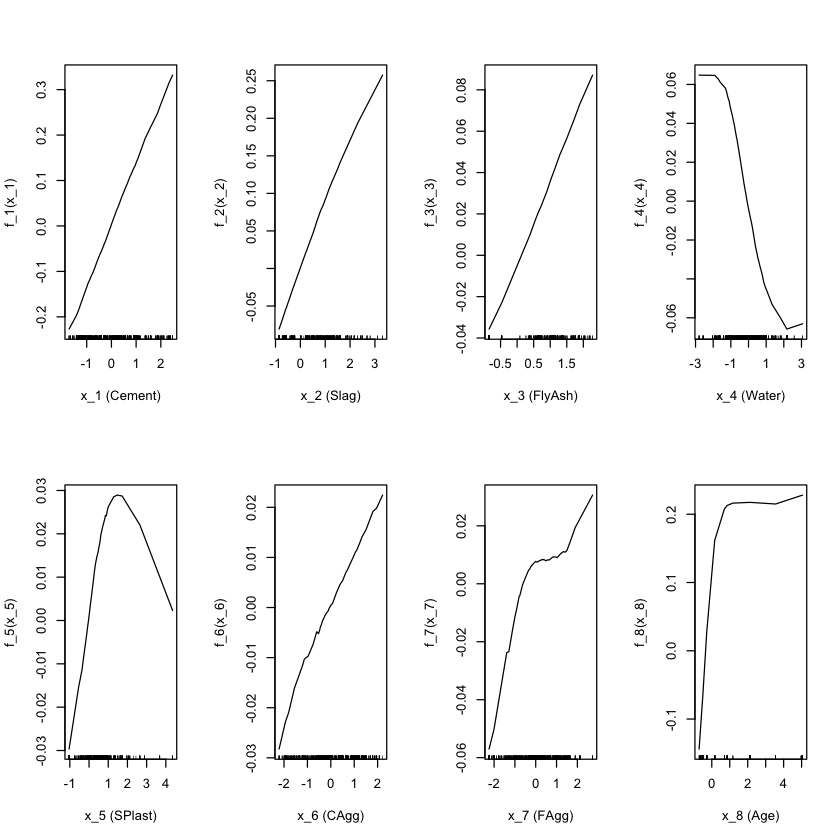

In [23]:
## Use ALEPlot package to create accumulated local effects (ALE) plots
library(ALEPlot)
yhat <- function(X.model, newdata) as.numeric(predict(X.model, newdata))
par(mfrow=c(2,4))
for (j in 1:8)  {ALEPlot(CRT1[,1:8], nn1, pred.fun=yhat, J=j, K=50, NA.plot = TRUE)
  rug(CRT1[,j]) }  ## This creates main effect ALE plots for all 8 predictors
par(mfrow=c(1,1))

[1] 50 27

[1] 50 12

[1] 27 12

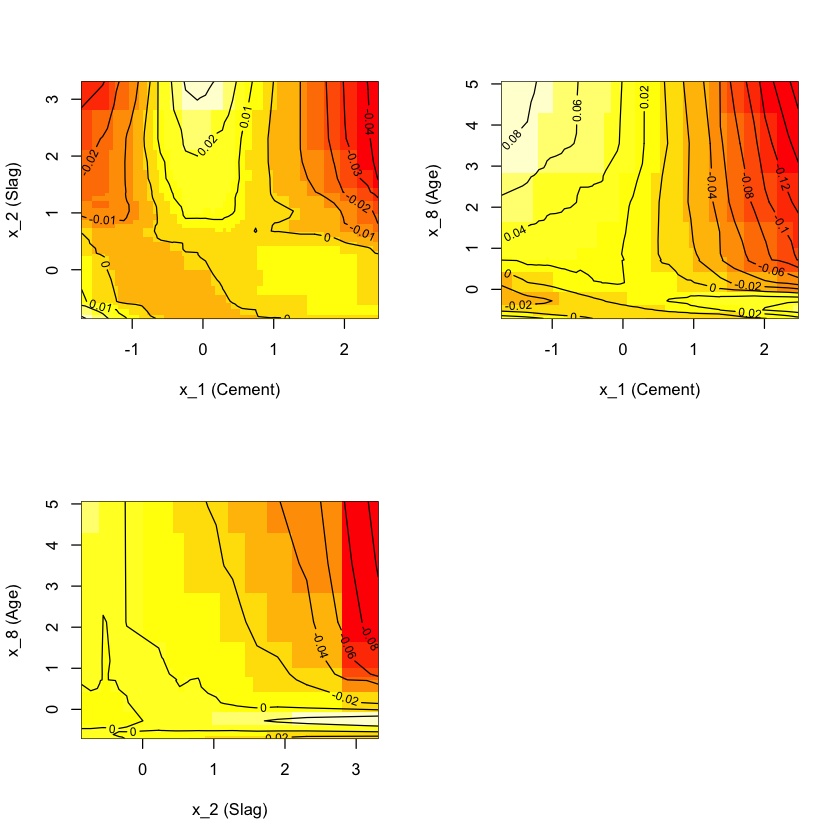

In [24]:
## This creates 2nd-order interaction ALE plots for x1, x2, x8
par(mfrow=c(2,2))  
ALEPlot(CRT1[,1:8], nn1, pred.fun=yhat, J=c(1,2), K=50, NA.plot = TRUE)$K
ALEPlot(CRT1[,1:8], nn1, pred.fun=yhat, J=c(1,8), K=50, NA.plot = TRUE)$K
ALEPlot(CRT1[,1:8], nn1, pred.fun=yhat, J=c(2,8), K=50, NA.plot = TRUE)$K
par(mfrow=c(1,1))

**How do we see whether if there is an interaction with Cement and Slag or not?**

If there is an interaction between cement and age, then the effect of cement on y will be depend on the value of age. In the above plot, we can see that when age=0, then f(cement, age), which is the interaction effects having main effect subtract out, does not change when cement goes from -1 to 2. In other words, there is no interaction effect when age=0.

When age=4, we see that the interaction effect goes from -0.1 to 0.15. In other words, the effect of cement on y do depend on the value of age. The effect is 0.25. In the main effect ALE plot, we see that the effect of Cement is from -0.2 to 0.3, with total effect equals 0.5. Therefore, the percentage of interaction effect is around 50%, which is quite high.

In conclusion, there is an interaction with cement and age, and we should keep that in mind.

# <a id='nn_cla'>Neural Network Model for Classification</a>

**Note**:

    * just put the response y as type factor, nnet function will treat it as 
    * usually we use misclassification rate as the metric to check


In [47]:
FGL<-read.table("Data_for_Lecture_Examples/fgl.txt",sep="\t")
z<-(FGL$type == "WinF") | (FGL$type == "WinNF")
y<-as.character(FGL$type)
y[z]<-"Win"; y[!z]<-"Other"
FGL<-data.frame(FGL,"type_bin"=as.factor(y))  #add a binary factor response column
y[y == "Win"]<-1;y[y == "Other"]<-0;
FGL<-data.frame(FGL,"type01"=as.numeric(y))  #also add a binary numeric response column
FGL1<-FGL
k<-ncol(FGL)-3;
FGL1[1:k]<-sapply(FGL1[1:k], function(x) (x-mean(x))/sd(x)) #standardize predictors
head(FGL)

RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_bin,type01
3.01,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,WinF,Win,1
-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,WinF,Win,1
-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,WinF,Win,1
-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,WinF,Win,1
-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,WinF,Win,1
-2.04,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,WinF,Win,1


In [48]:
##Now use multiple reps of CV to compare Neural Nets and logistic reg models###
Nrep<-20 #number of replicates of CV
K<-3  #K-fold CV on each replicate
n.models = 3 #number of different models to fit
n=nrow(FGL1)
y<-FGL1[[12]]
yhat=matrix(0,n,n.models)
CV.rate<-matrix(0,Nrep,n.models)
for (j in 1:Nrep) {
  Ind<-CVInd(n,K)
  for (k in 1:K) {
     out<-nnet(type_bin~.,FGL1[-Ind[[k]],c(1:9,11)],linout=F,skip=F,size=10,decay=.3, maxit=1000,trace=F)
     phat<-as.numeric(predict(out,FGL1[Ind[[k]],c(1:9,11)]));  yhat[Ind[[k]],1]<-as.numeric(phat >= 0.5)
     out<-nnet(type_bin~.,FGL1[-Ind[[k]],c(1:9,11)],linout=F,skip=F,size=10,decay=0, maxit=1000,trace=F)
     phat<-as.numeric(predict(out,FGL1[Ind[[k]],c(1:9,11)]));  yhat[Ind[[k]],2]<-as.numeric(phat >= 0.5)
     out<-glm(type_bin~.,FGL1[-Ind[[k]],c(1:9,11)],family=binomial(link="logit"))
     phat<-as.numeric(predict(out,FGL1[Ind[[k]],c(1:9,11)],type="response"));  yhat[Ind[[k]],3]<-as.numeric(phat >= 0.5)
  } #end of k loop
  CV.rate[j,]=apply(yhat,2,function(x) sum(y != x)/n)
} #end of j loop
CV.rate
CV.rateAve<- apply(CV.rate,2,mean); CV.rateAve #averaged CV misclass rate
CV.rateSD <- apply(CV.rate,2,sd); CV.rateSD   #SD of CV misclass rate

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

0.1448598,0.1822430,0.1542056
0.1495327,0.2149533,0.1728972
0.1448598,0.1728972,0.1775701
0.1542056,0.1775701,0.1542056
0.1588785,0.2149533,0.1869159
0.1308411,0.2383178,0.1542056
0.1588785,0.1728972,0.1635514
0.1355140,0.1869159,0.1588785
0.1401869,0.1588785,0.1728972
0.1588785,0.2570093,0.1588785
0.1682243,0.2289720,0.1588785


[1] 0.1504673 0.1985981 0.1637850

[1] 0.009045851 0.026542368 0.010223763

In [ ]:
#############Visualizing the effects of the predictors####################
fgl.nn1<-nnet(type_bin~., FGL1[,c(1:9,11)], linout=F, skip=F, size=10, decay=.3, maxit=1000, trace=F) ##From CV, these are about the best tuning parameters
# summary(fgl.nn1)

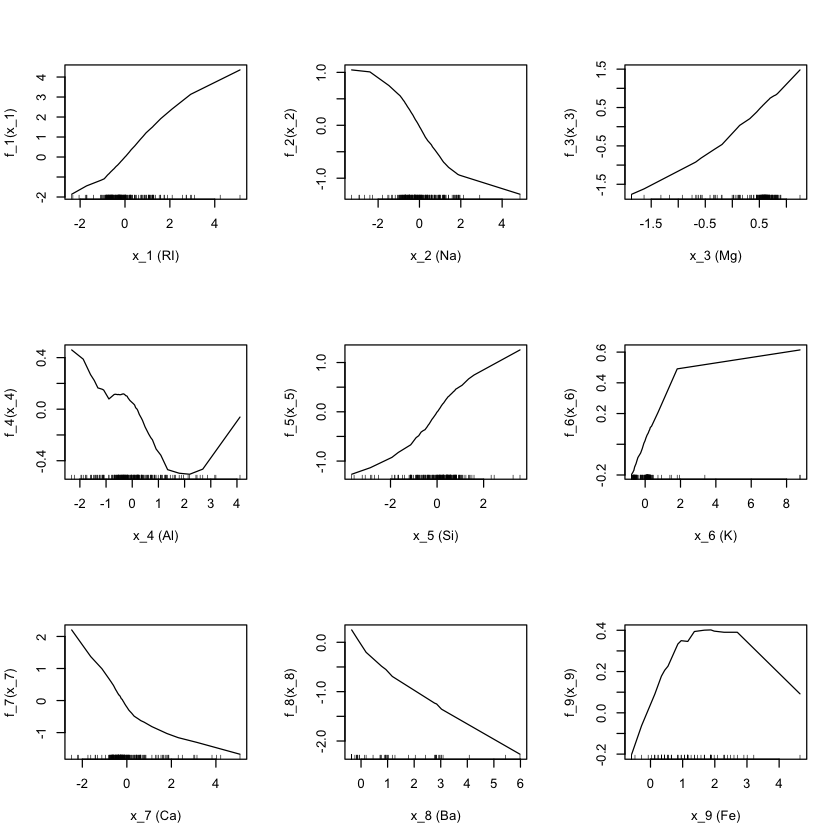

In [51]:
## Use ALEPlot package to create accumulated local effects (ALE) plots
library(ALEPlot)
yhat <- function(X.model, newdata) {p.hat = as.numeric(predict(X.model, newdata, type="raw")); log(p.hat/(1-p.hat))}  ## to plot the log-odds
par(mfrow=c(3,3))
for (j in 1:9)  {ALEPlot(FGL1[,1:9], fgl.nn1, pred.fun=yhat, J=j, K=50, NA.plot = TRUE)
  rug(FGL1[,j]) }  ## This creates main effect ALE plots for all 9 predictors
par(mfrow=c(1,1))

[1] 50 38

[1] 50 49

[1] 38 49

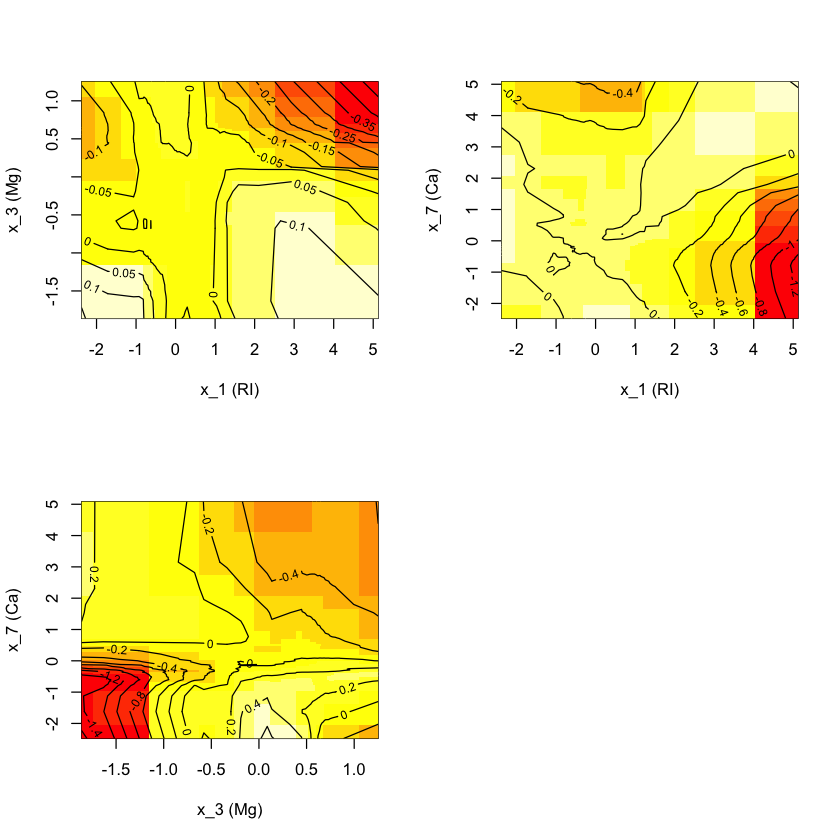

In [54]:
par(mfrow=c(2,2))  ## This creates 2nd-order interaction ALE plots for x1, x3, x7
ALEPlot(FGL1[,1:9], fgl.nn1, pred.fun=yhat, J=c(1,3), K=50, NA.plot = TRUE)$K
ALEPlot(FGL1[,1:9], fgl.nn1, pred.fun=yhat, J=c(1,7), K=50, NA.plot = TRUE)$K
ALEPlot(FGL1[,1:9], fgl.nn1, pred.fun=yhat, J=c(3,7), K=50, NA.plot = TRUE)$K
par(mfrow=c(1,1))

In [58]:
#############Same, but use the original 6-category response######
fgl.nn1<-nnet(type~.,FGL1[,c(1:10)],linout=F,skip=F,size=10,decay=.05,maxit=1000,trace=F)
##output the class probabilities
phat<-predict(fgl.nn1,type="raw")
#phat[1:20,]
#apply(phat,1,sum)  #you can see that the 6 predicted class probabilities sum to 1.0
##output the class with the largest class probability
yhat<-predict(fgl.nn1,type="class")
y<-FGL1$type 
sum(y != yhat)/length(y)  #training misclassification rate

[1] 0.04205607

In [61]:
head(predict(fgl.nn1,type="raw"))

,Con,Head,Tabl,Veh,WinF,WinNF
1,2.623141e-05,6.894196e-04,0.0002429938,0.002045634,0.9423152,0.05468049
2,5.637964e-05,4.221547e-02,0.0051172879,0.006800734,0.9313567,0.01445338
3,1.623992e-03,6.873370e-03,0.0051226029,0.012759841,0.5921913,0.38142885
4,4.194603e-04,8.316050e-04,0.0002625356,0.009273027,0.1854103,0.80380308
5,7.318109e-04,7.527528e-03,0.0007204336,0.002702969,0.8003301,0.18798715
6,3.949870e-03,3.337622e-05,0.0008400243,0.012011066,0.4752634,0.50790229


# Tree

### <a id="tree_reg">Regression</a>

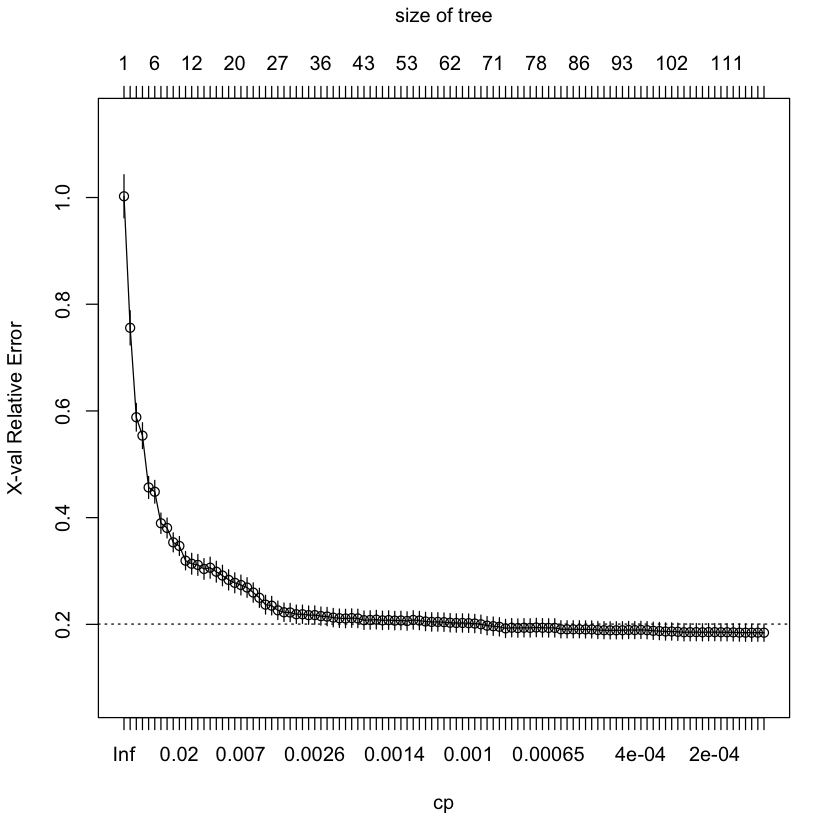

In [73]:
#do not have to standardize or transform predictors to fit trees
library(rpart)
control <- rpart.control(minbucket = 5, cp = 0.0001, maxsurrogate = 0, usesurrogate = 0, xval = 10)
CRT.tr <- rpart(Strength ~ .,CRT, method = "anova", control = control)
plotcp(CRT.tr)  #plot of CV r^2 vs. size
#printcp(CRT.tr)  #same info is in CRT.tr$cptable

In [78]:
#prune back to optimal size, according to plot of CV 1-r^2
CRT.tr1 <- prune(CRT.tr, cp=0.0015)  #approximately the best size pruned tree
CRT.tr1$variable.importance
CRT.tr1$cptable[nrow(CRT.tr1$cptable),] #shows training and CV 1-r^2, and other things


Cement       Age     Water      Slag      CAgg    SPlast      FAgg    FlyAsh 
99230.149 87597.201 27920.346 27417.177  3810.352  3719.861  2307.250  1220.903

CP      nsplit   rel error      xerror        xstd 
 0.00150000 44.00000000  0.11822730  0.20881750  0.01741434

In [79]:
#prune and plot a little smaller tree than the optimal one, just for display
CRT.tr2 <- prune(CRT.tr, cp=0.007)  #bigger cp gives smaller size tree
CRT.tr2
par(cex=.9); 
#plot(CRT.tr2, uniform=F); text(CRT.tr2, use.n = T); par(cex=1)

yhat<-predict(CRT.tr2); e<-CRT$Strength-yhat

#check to see training r^2 agrees with what is in cptable
c(1-var(e)/var(CRT$Strength), 1-CRT.tr2$cptable[nrow(CRT.tr2$cptable),3]) 

n= 1030 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 1030 287175.20000 35.81796  
    2) Age< 21 324  49754.23000 23.54123  
      4) Cement< 354.5 230  18387.25000 18.70622  
        8) Age< 10.5 173   9063.38200 15.71393  
         16) Cement< 255.25 111   2983.66300 13.07559 *
         17) Cement>=255.25 62   3923.75900 20.43742 *
        9) Age>=10.5 57   3073.50100 27.78807 *
      5) Cement>=354.5 94  12834.18000 35.37160  
       10) Water>=183.05 36   3801.30200 27.91917 *
       11) Water< 183.05 58   5792.48500 39.99724  
         22) Age< 5 28    913.24500 32.86000 *
         23) Age>=5 30   2121.67600 46.65867 *
    3) Age>=21 706 166177.90000 41.45204  
      6) Cement< 355.95 547  88933.96000 36.95020  
       12) Cement< 164.8 126  10420.69000 25.99714  
         24) Slag< 115.5 33    484.49760 14.71152 *
         25) Slag>=115.5 93   4241.72600 30.00172 *
       13) Cement>=164.8 421  58873.04000 40.22831  
         26) Water>=176 276  2795

[1] 0.7993559 0.7993559

### <a id="tree_cla">Classification</a>

**Note**:
* The output of rpart tree shows the misclassification rate.
* The output of rerror, xerror is the misclassification rate/ stump misclassification rate


Classification tree:
rpart(formula = type_bin ~ ., data = FGL[, c(1:9, 11)], method = "class", 
    control = control)

Variables actually used in tree construction:
[1] Al Ba Ca Fe K  Mg Na RI Si

Root node error: 68/214 = 0.31776

n= 214 

         CP nsplit rel error  xerror     xstd
1 0.5147059      0  1.000000 1.00000 0.100165
2 0.1029412      1  0.485294 0.50000 0.078643
3 0.0294118      2  0.382353 0.45588 0.075717
4 0.0220588      6  0.264706 0.48529 0.077693
5 0.0147059     10  0.176471 0.48529 0.077693
6 0.0098039     19  0.044118 0.52941 0.080472
7 0.0010000     22  0.014706 0.50000 0.078643


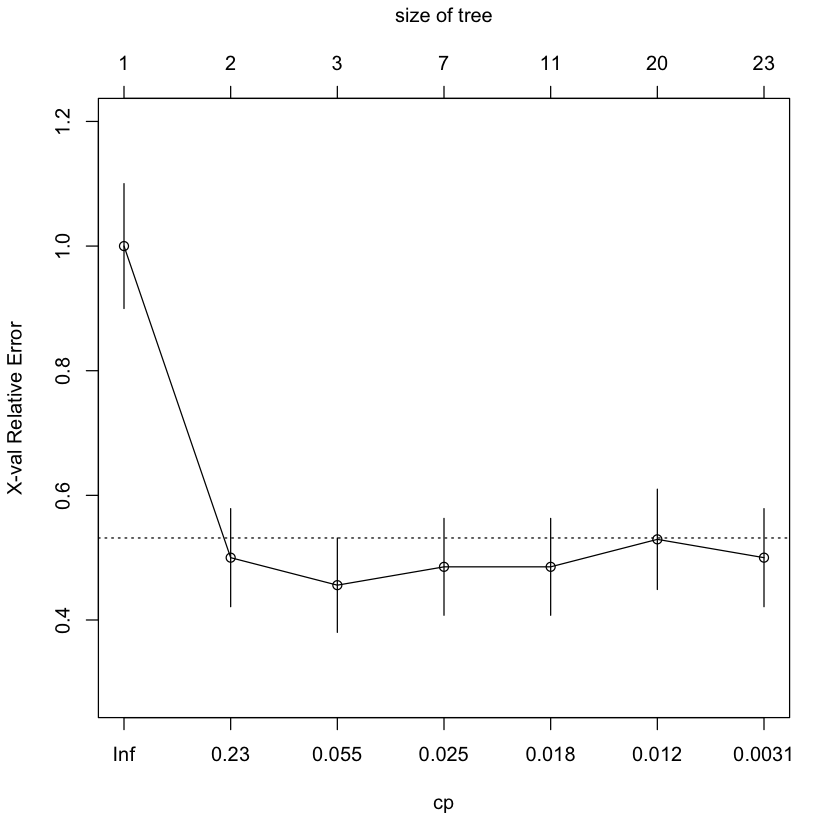

In [82]:
library(rpart)
control <- rpart.control(minbucket = 1, cp = 0.001, maxsurrogate = 0, usesurrogate = 0, xval = 10)
FGL.tr <- rpart(type_bin~., FGL[,c(1:9,11)], method = "class", control = control)
plotcp(FGL.tr)
printcp(FGL.tr)  #same info in FGL.tr$cptable

In [92]:
#prune to optimal size
FGL.tr1 <- prune(FGL.tr, cp=0.055)  #approximately the cp corresponding to the optimal size
FGL.tr1

n= 214 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 214 68 Win (0.3177570 0.6822430)  
  2) Mg< 2.695 61 13 Other (0.7868852 0.2131148)  
    4) RI< 6.22 54  6 Other (0.8888889 0.1111111) *
    5) RI>=6.22 7  0 Win (0.0000000 1.0000000) *
  3) Mg>=2.695 153 20 Win (0.1307190 0.8692810) *

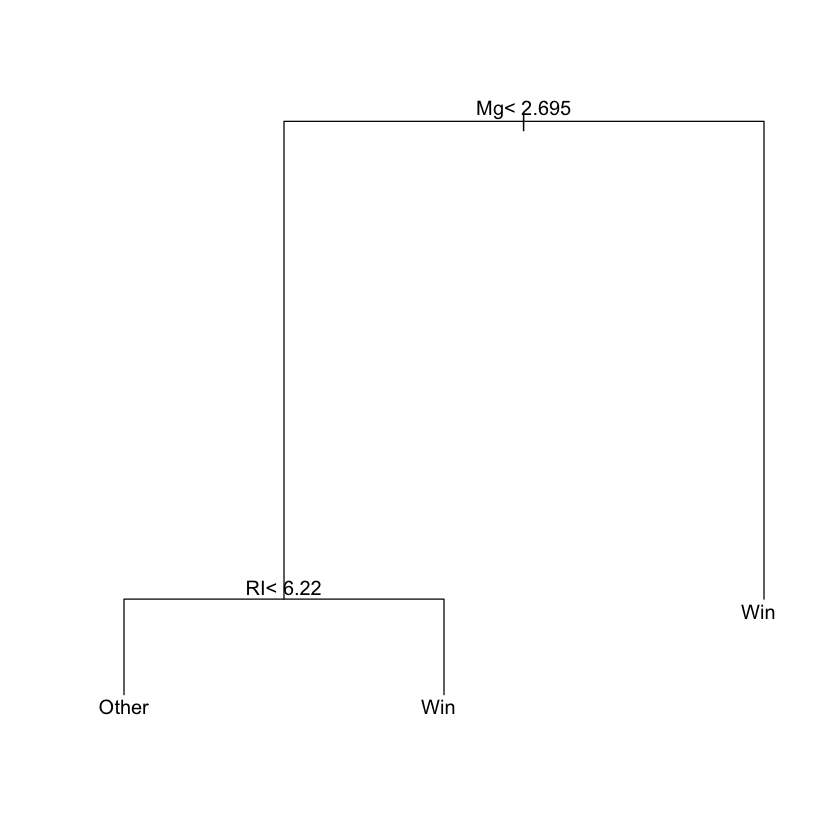

In [93]:
par(cex=1); plot(FGL.tr1, uniform=F); text(FGL.tr1, use.n = F); par(cex=1)

In [94]:
FGL.tr1$variable.importance

Mg       RI 
37.55479  9.79235

In [95]:
FGL.tr1$cptable[nrow(FGL.tr1$cptable),] 

CP     nsplit  rel error     xerror       xstd 
0.05500000 2.00000000 0.38235294 0.45588235 0.07571651

In [97]:
#calculate training and CV misclass rates
FGL.tr1$cptable[nrow(FGL.tr1$cptable),c(3,4)]*min(table(FGL$type_bin)/nrow(FGL))  #training and cv misclass rates

rel error    xerror 
0.1214953 0.1448598

In [99]:
#check the training misclass rate
yhat<-predict(FGL.tr1, type="class")
sum(yhat != FGL$type_bin)/nrow(FGL) 

[1] 0.1214953

### Same but for the original 6-category response


Classification tree:
rpart(formula = type ~ ., data = FGL[, c(1:10)], method = "class", 
    control = control)

Variables actually used in tree construction:
[1] Al Ba Ca Fe K  Mg Na RI Si

Root node error: 138/214 = 0.64486

n= 214 

          CP nsplit rel error  xerror     xstd
1  0.2065217      0  1.000000 1.04348 0.049733
2  0.0724638      2  0.586957 0.59420 0.051536
3  0.0579710      3  0.514493 0.57246 0.051156
4  0.0362319      4  0.456522 0.49275 0.049357
5  0.0326087      5  0.420290 0.47101 0.048749
6  0.0217391      7  0.355072 0.43478 0.047616
7  0.0144928      8  0.333333 0.44203 0.047855
8  0.0108696     15  0.231884 0.45652 0.048314
9  0.0072464     18  0.195652 0.47826 0.048957
10 0.0036232     38  0.050725 0.52899 0.050256
11 0.0000100     44  0.028986 0.53623 0.050419


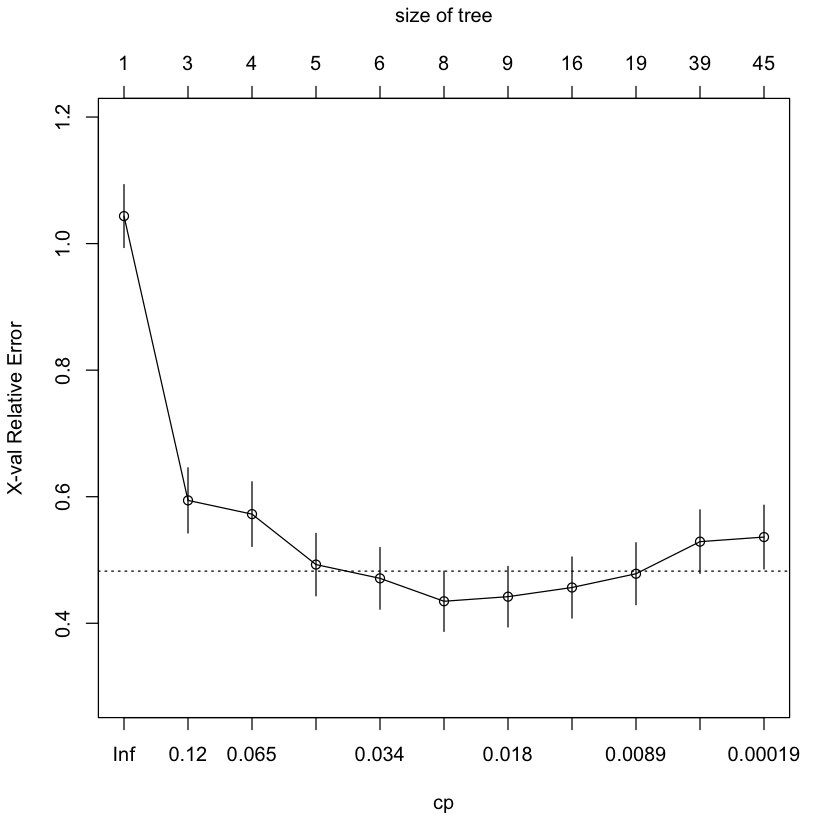

In [101]:
library(rpart)
control <- rpart.control(minbucket = 1, cp = 0.00001, maxsurrogate = 0, usesurrogate = 0, xval = 10)
FGL.tr <- rpart(type~.,FGL[,c(1:10)], method = "class", control = control)
plotcp(FGL.tr)
printcp(FGL.tr)  #same info in FGL.tr$cptable

In [102]:
#prune to optimal size
FGL.tr1 <- prune(FGL.tr, cp=0.01)  #approximately the cp corresponding to the optimal size
FGL.tr1

n= 214 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 214 138 WinNF (0.061 0.14 0.042 0.079 0.33 0.36)  
    2) Ba>=0.335 29   3 Head (0.034 0.9 0 0 0.034 0.034) *
    3) Ba< 0.335 185 110 WinNF (0.065 0.016 0.049 0.092 0.37 0.41)  
      6) Al>=1.42 72  28 WinNF (0.15 0.014 0.083 0.056 0.083 0.61)  
       12) Mg< 2.26 20   9 Con (0.55 0.05 0.25 0 0 0.15)  
         24) Na< 13.495 12   1 Con (0.92 0 0 0 0 0.083) *
         25) Na>=13.495 8   3 Tabl (0 0.12 0.62 0 0 0.25)  
           50) RI< 1.68 5   0 Tabl (0 0 1 0 0 0) *
           51) RI>=1.68 3   1 WinNF (0 0.33 0 0 0 0.67) *
       13) Mg>=2.26 52  11 WinNF (0 0 0.019 0.077 0.12 0.79)  
         26) RI>=-0.675 12   7 WinNF (0 0 0.083 0.25 0.25 0.42)  
           52) RI>=-0.28 9   4 WinNF (0 0 0.11 0.33 0 0.56)  
            104) RI< -0.02 2   0 Veh (0 0 0 1 0 0) *
            105) RI>=-0.02 7   2 WinNF (0 0 0.14 0.14 0 0.71) *
           53) RI< -0.28 3   0 WinF (0 0 0 0 1 0) *
         27) RI< -0

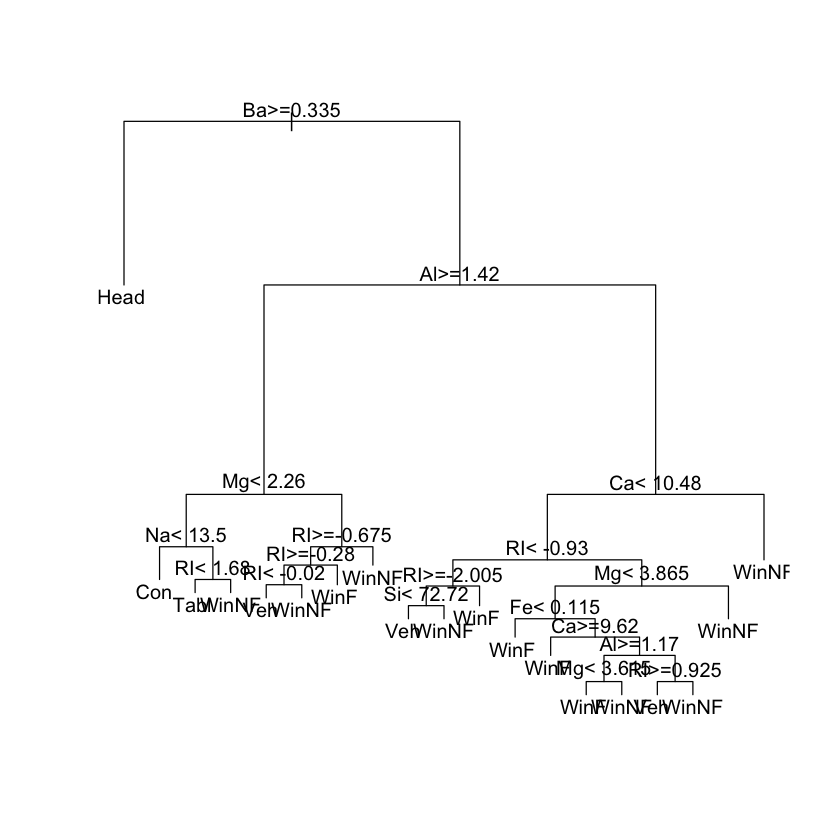

In [103]:
par(cex=1); plot(FGL.tr1, uniform=F); text(FGL.tr1, use.n = F); par(cex=1)

In [107]:
FGL.tr1$variable.importance

Ba        RI        Mg        Al        Ca        Na        Fe        Si 
26.044912 22.861814 20.020468 19.585776 10.768054  6.116667  3.743814  2.500000

In [108]:
FGL.tr1$cptable[nrow(FGL.tr1$cptable),] 

CP      nsplit   rel error      xerror        xstd 
 0.01000000 18.00000000  0.19565217  0.47826087  0.04895723

In [112]:
stump.MisAcc = 1-max(table(FGL$type))/nrow(FGL)

In [114]:
#see what the predicted class probabilities are
yhat<-predict(FGL.tr1, type="prob")

stump.MisAcc = 1-max(table(FGL$type))/nrow(FGL)

#training and cv misclass rates
FGL.tr1$cptable[nrow(FGL.tr1$cptable),c(3,4)]*stump.MisAcc

rel error    xerror 
0.1261682 0.3084112